In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rubin_sim.maf as maf
from rubin_sim.data import get_baseline
from rubin_scheduler.scheduler.utils import SkyAreaGenerator
import sqlite3
from astropy.time import Time

/home/idies/lsst/conda/miniconda3-py37_4.8.2/envs/rubin/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def calculate_total_qsos_band(bundle):
    """
    Calculate the total number of QSOs for a given metric bundle.
    
    Parameters:
    bundle (MetricBundle): The metric bundle to calculate QSOs from.
    
    Returns:
    float: The total number of QSOs.
    """
    summary = maf.SumMetric(col='metric')
    bundle.set_summary_metrics([summary])
    bundle.compute_summary_stats()
    total_qsos = bundle.summary_values[summary.name]
    return total_qsos

def calculate_qso_numbers(database_file, nside, maps, outdir):
    """
    Calculate QSO numbers for different redshifts over 10 years for u-band.

    Parameters:
    baseline (str): Path to the baseline database file.
    nside (int): HEALPix resolution parameter.
    maps (array): Array of HEALPix IDs to use.
    outdir (str): Output directory for results.
    ourdir_db (str): Directory for results database.

    Returns:
    dict: Dictionary of metric bundles for each filter, redshift, and month.
    """
    annual_bundles = {}
    dustmap = maf.DustMap(nside=nside)
    slicer = maf.HealpixSubsetSlicer(nside=nside, use_cache=False, hpid=maps)
    results = {}
    f = 'u'
    Redshift = np.arange(0.4, 6.8, 0.1)
    results[f] = {}
    
    for red in Redshift:
        metric = maf.QSONumberCountsMetric(f, zmax=round(red, 1))
        sql = f'filter = "{f}"'
        bundle = maf.MetricBundle(metric, slicer, sql, run_name=os.path.basename(database_file).replace('.db', ''), maps_list=[dustmap], info_label=f'{f} band redshift {red:.1f}')
        annual_bundles[round(red, 1)] = bundle
    
    
    baseline_file = baseline
    run_name = os.path.split(baseline_file)[-1].replace('.db', '')
    
    bundles = {}
    dustmap = maf.DustMap(nside=nside)
    slicer = maf.HealpixSubsetSlicer(nside=nside, use_cache=False, hpid=maps)
    for f in ('u', 'g', 'r', 'i', 'z', 'y'):
        metric = maf.QSONumberCountsMetric(f, zmax=6.7)
        #sql = f'target_name not like "DD%" and filter = "{f}"'
        sql = f'filter = "{f}"'
        bundle = maf.MetricBundle(metric, slicer, sql, run_name=run_name, maps_list=[dustmap], info_label=f'{f} band')
        bundles[f] = bundle
    
    results_db_dir = os.path.join(outdir, os.path.basename(database_file).replace('.db', ''))
    if not os.path.exists(results_db_dir):
        os.makedirs(results_db_dir)
    results_db = maf.db.ResultsDb(out_dir=ourdir_db)
    
    bundle_group = maf.MetricBundleGroup(annual_bundles, database_file, out_dir=results_db_dir, results_db=results_db)
    bundle_group.run_all()
    
    qso_numbers = {}
    for red in Redshift:
        red_rounded = round(red, 1)
        qso_numbers[red_rounded] = calculate_total_qsos(annual_bundles[round(red, 1)])
    return qso_numbers

def process_all_databases(database_dir, outdir, nside, maps):
    """Process all database files in the specified directory and compile results."""
    database_files = [os.path.join(database_dir, f) for f in os.listdir(database_dir) if f.endswith('.db')]
    all_results = []
    indices = []
    
    for db_file in database_files:
        print(f"Processing {db_file}...")
        results = calculate_qso_numbers(db_file, nside, maps, outdir)
        all_results.append(results)
        indices.append(os.path.basename(db_file).replace('.db', ''))
    
    df = pd.DataFrame(all_results, index=indices)
    return df

# Parameters
database_dir = '/home/idies/workspace/Temporary/LiGuodong/scratch/EM5_MAFOutput/U_band_Cadence'  # Directory where .db files are stored
outdir = '/home/idies/workspace/Temporary/LiGuodong/scratch/EM5_MAFOutput/U_band_Result'    # Directory to save results
nside = 64

# Generate survey areas
survey_areas = SkyAreaGenerator(nside=nside)
map_footprints, map_labels = survey_areas.return_maps()

# Select HEALPix IDs for specific regions
# ['','LMC_SMC','bulge','dusty_plane','lowdust','nes','scp','virgo']
maps = np.where(
    (map_labels == 'LMC_SMC') |
    (map_labels == 'bulge') |
    (map_labels == 'dusty_plane') |
    (map_labels == '') |
    (map_labels == 'lowdust') |
    (map_labels == 'nes') |
    (map_labels == 'scp') |
    (map_labels == 'virgo')
)[0]

# Process all databases
all_qso_results = process_all_databases(database_dir, outdir, nside, maps)

# Convert results to a DataFrame and save to CSV
df = pd.DataFrame(all_qso_results)
csv_output_path = "./qso_numbers_summary.csv"
df.to_csv(csv_output_path)
print(f"Saved QSO numbers summary to {csv_output_path}")


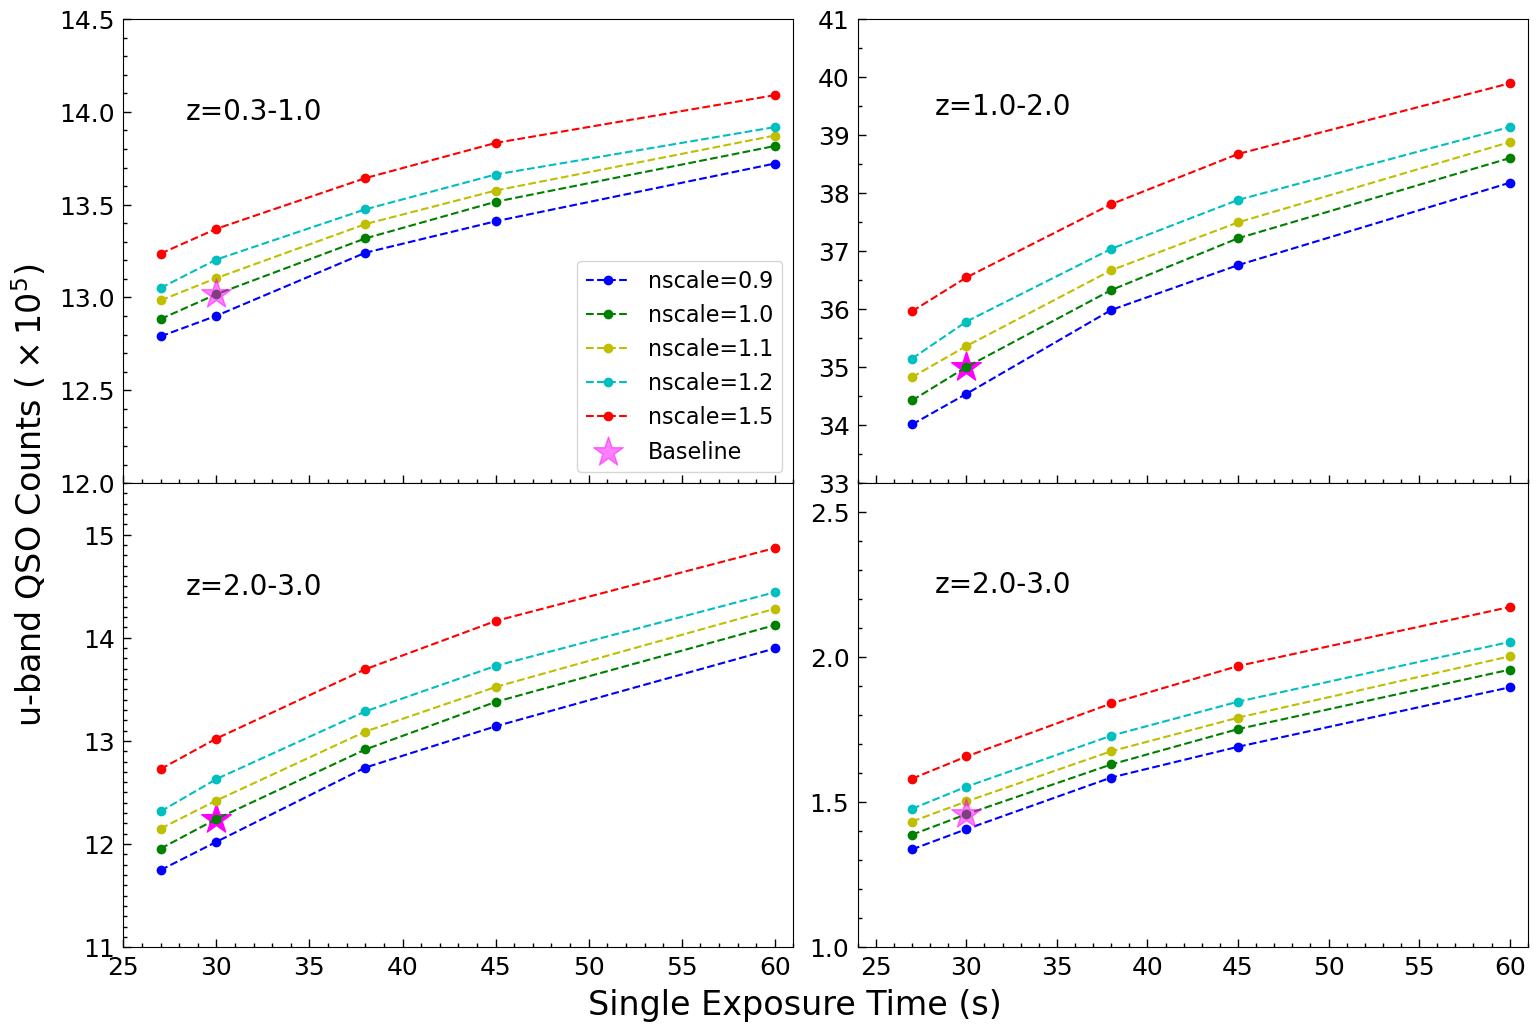

In [3]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

csv_file_path = './qso_numbers_summary.csv'
df = pd.read_csv(csv_file_path, index_col=0)

exp_times     = [27, 30, 38, 45, 60]
nscale_values = [0.9,1.0,1.1,1.2,1.5]

colors = ['b', 'g', 'y', 'c', 'r']
labels = ['nscale=0.9', 'nscale=1.0', 'nscale=1.1', 'nscale=1.2', 'nscale=1.5']

fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharex='col', 
                            gridspec_kw={'hspace': 0})
axs = axs.flatten()

#z=0.3-1
for i in range(len(nscale_values)):
    y_data = []
    for j in exp_times:
        db_name = 'internal_u_expt'+str(j)+'_nscale'+str(nscale_values[i])+'v3.4_10yrs'
        y = float(df["1.0"][db_name])
        y_data.append(y)
    axs[0].plot(exp_times, np.array(y_data)/1e5, color=colors[i], marker='o', linestyle='--',label=labels[i])
axs[0].text(32, 14, 'z=0.3-1.0', fontsize=20, verticalalignment='center', horizontalalignment='center')
ymajorLocator = MultipleLocator(0.5)
yminorLocator = MultipleLocator(0.1)
axs[0].yaxis.set_major_locator(ymajorLocator)
axs[0].yaxis.set_minor_locator(yminorLocator)
axs[0].set_ylim(12, 14.5)

#z=1-2
for i in range(len(nscale_values)):
    y_data = []
    for j in exp_times:
        db_name = 'internal_u_expt'+str(j)+'_nscale'+str(nscale_values[i])+'v3.4_10yrs'
        y = float(df["2.0"][db_name])-float(df["1.0"][db_name])
        y_data.append(y)
    axs[1].plot(exp_times, np.array(y_data)/1e5, color=colors[i], marker='o', linestyle='--',label=labels[i])
axs[1].text(32, 39.5, 'z=1.0-2.0', fontsize=20, verticalalignment='center', horizontalalignment='center')
ymajorLocator = MultipleLocator(1)
yminorLocator = MultipleLocator(0.5)
axs[1].yaxis.set_major_locator(ymajorLocator)
axs[1].yaxis.set_minor_locator(yminorLocator)
axs[1].set_ylim(33, 41)


#z=2-3
for i in range(len(nscale_values)):
    y_data = []
    for j in exp_times:
        db_name = 'internal_u_expt'+str(j)+'_nscale'+str(nscale_values[i])+'v3.4_10yrs'
        y = float(df["3.0"][db_name])-float(df["2.0"][db_name])
        y_data.append(y)
    axs[2].plot(exp_times, np.array(y_data)/1e5, color=colors[i], marker='o', linestyle='--',label=labels[i])
axs[2].text(32, 14.5, 'z=2.0-3.0', fontsize=20, verticalalignment='center', horizontalalignment='center')
ymajorLocator = MultipleLocator(1)
yminorLocator = MultipleLocator(0.1)
axs[2].yaxis.set_major_locator(ymajorLocator)
axs[2].yaxis.set_minor_locator(yminorLocator)
axs[2].set_ylim(11, 15.5)

#z=3-4
for i in range(len(nscale_values)):
    y_data = []
    for j in exp_times:
        db_name = 'internal_u_expt'+str(j)+'_nscale'+str(nscale_values[i])+'v3.4_10yrs'
        y = float(df["4.0"][db_name])-float(df["3.0"][db_name])
        y_data.append(y)
    axs[3].plot(exp_times, np.array(y_data)/1e5, color=colors[i], marker='o', linestyle='--',label=labels[i])
axs[3].text(32, 2.25, 'z=2.0-3.0', fontsize=20, verticalalignment='center', horizontalalignment='center')
ymajorLocator = MultipleLocator(0.5)
yminorLocator = MultipleLocator(0.1)
axs[3].yaxis.set_major_locator(ymajorLocator)
axs[3].yaxis.set_minor_locator(yminorLocator)
axs[3].set_ylim(1.0, 2.6)

db_name = 'internal_u_expt30_nscale1.0v3.4_10yrs'
x = np.array([30])
y1= np.array([float(df["2.0"][db_name])-float(df["1.0"][db_name])])
y2= np.array([float(df["3.0"][db_name])-float(df["2.0"][db_name])])
y3= np.array([float(df["1.0"][db_name])])
y4= np.array([float(df["4.0"][db_name])-float(df["3.0"][db_name])])
axs[1].scatter(x,y1/1e5,s=500,marker='*',c='magenta',facecolors='none',label='Baseline')
axs[2].scatter(x,y2/1e5,s=500,marker='*',c='magenta',facecolors='none',label='Baseline')
axs[0].scatter(x,y3/1e5,s=500,marker='*',c='magenta',facecolors='none',label='Baseline',zorder=100,alpha=0.5)
axs[3].scatter(x,y4/1e5,s=500,marker='*',c='magenta',facecolors='none',label='Baseline',zorder=100,alpha=0.5)

axs[0].set_xlim(25,61)
axs[1].set_xlim(25,61)
axs[2].set_xlim(25,61)
axs[3].set_xlim(24,61)

for i in range(4):
    xmajorLocator = MultipleLocator(5)
    xminorLocator = MultipleLocator(1)
    axs[i].xaxis.set_major_locator(xmajorLocator)
    axs[i].xaxis.set_minor_locator(xminorLocator)
    axs[i].tick_params(axis='both',which='major',tickdir='in',labelsize=18,width=1,pad=6,length=6,bottom=True, top=False, left=True, right=False)
    axs[i].tick_params(axis='both',which='minor',tickdir='in',width=1,length=3,bottom=True, top=False, left=True, right=False)
        

axs[0].legend(loc='lower right', fontsize=16)

fig.text(0.5, -0.01, 'Single Exposure Time (s)', ha='center', va='center', fontsize=24)
fig.text(-0.01, 0.5, r'u-band QSO Counts ($\rm \times 10^{5}$)', ha='center', va='center', rotation='vertical', fontsize=24)
plt.tight_layout()
plt.show()
